In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn

import vsem_jax as vsem
from vsem_inv_prob import InvProb, VSEMPrior, VSEMLikelihood

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

rng = np.random.default_rng(6435)


# Exact Inverse Problem

In [2]:
n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.3**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood, proposal_cov=proposal_cov)

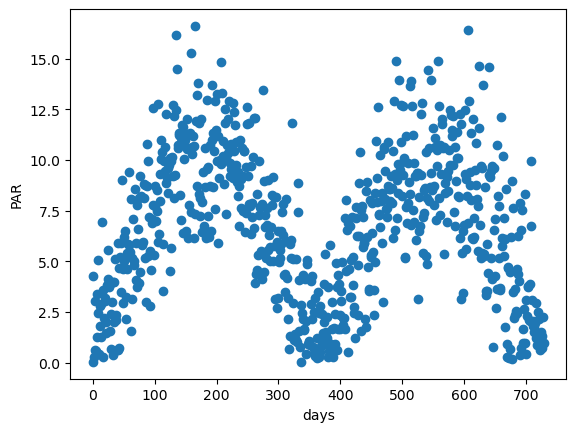

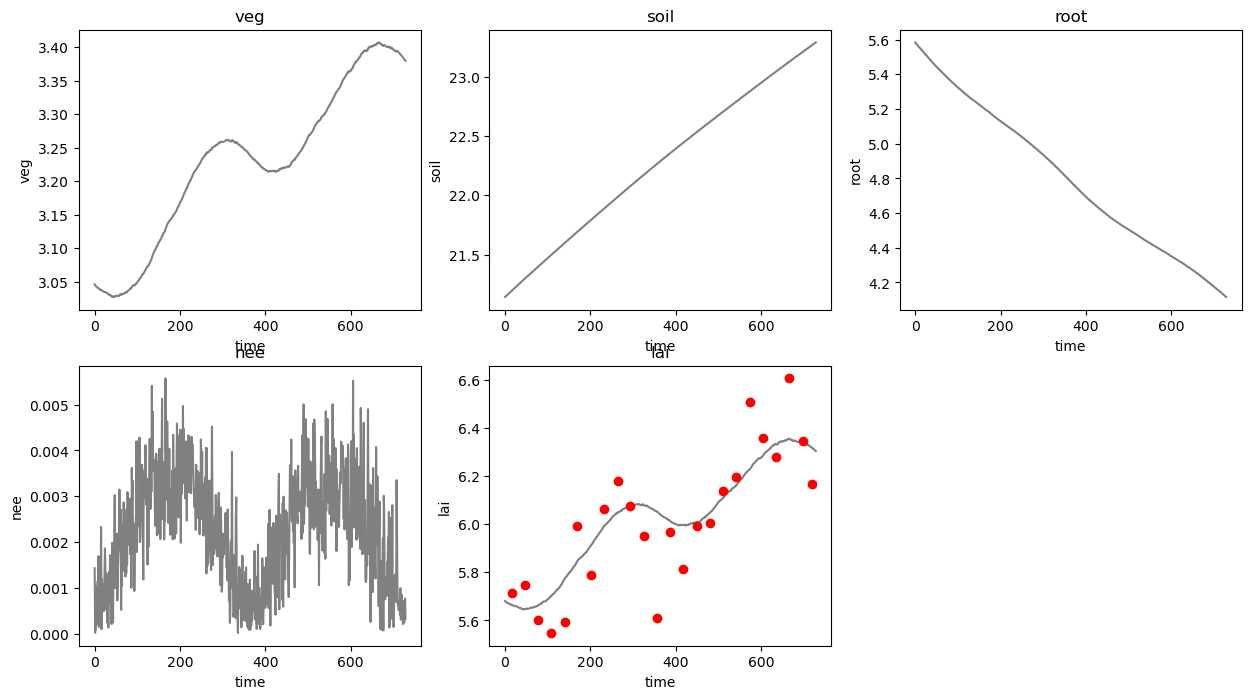

In [3]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

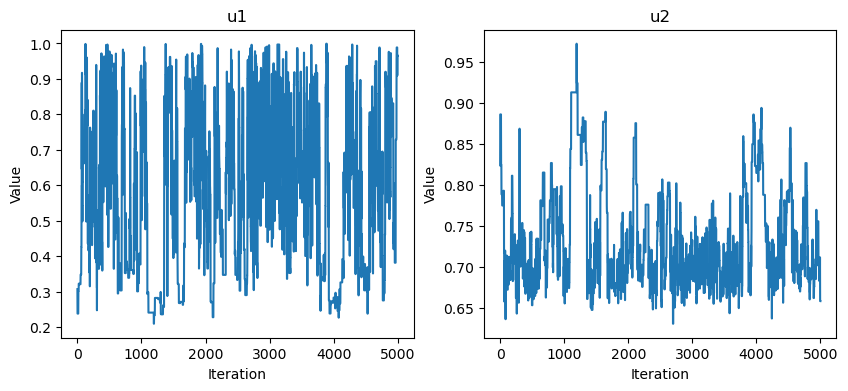

In [4]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=10000)

display(trace_plot)

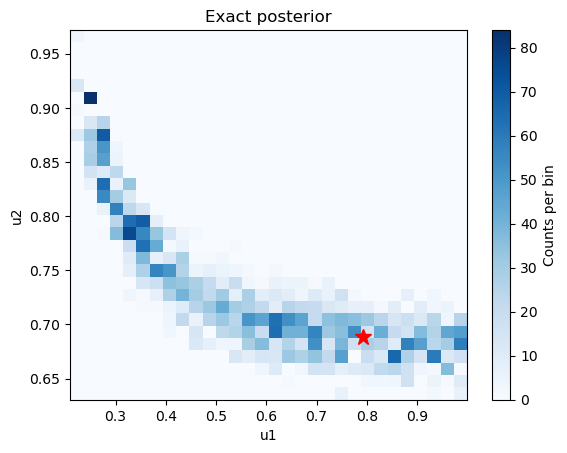

In [5]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

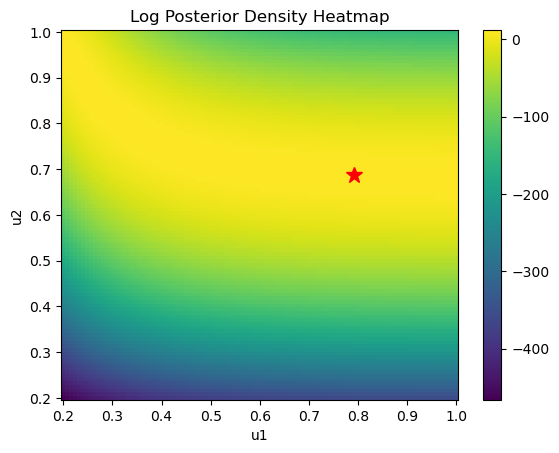

In [7]:
n_grid_1d = 100
u1_supp = prior.dists[par_names[0]].support()
u2_supp = prior.dists[par_names[1]].support()
u1_grid = np.linspace(u1_supp[0], u1_supp[1], n_grid_1d)
u2_grid = np.linspace(u2_supp[0], u2_supp[1], n_grid_1d)

U1_grid, U2_grid = np.meshgrid(u1_grid, u2_grid, indexing='xy')
U = np.stack([U1_grid.ravel(), U2_grid.ravel()], axis=1)
log_post = inv_prob.log_posterior_density(U)
log_post_grid = log_post.reshape(U1_grid.shape)

plt.pcolormesh(U1_grid, U2_grid, log_post_grid, shading='auto', cmap='viridis')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.title("Log Posterior Density Heatmap")
plt.xlabel("u1")
plt.ylabel("u2")
plt.colorbar()
plt.show()

# GP Surrogate Model

In [8]:
# Initial design for emulator
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
import gpjax as gpx
from flax import nnx
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)
key = jr.key(123)

/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
n = 10
x_design = jnp.asarray(prior.sample(n))
y_design = jnp.asarray(inv_prob.log_posterior_density(x_design)).reshape((-1,1))

design = gpx.Dataset(X=x_design, y=y_design)

In [10]:
# Prior Kernel
lengthscales = jnp.array([0.2, 0.2])
scale_squared = gpx.parameters.PositiveReal(design.y.var())
kernel = gpx.kernels.RBF(lengthscale=lengthscales, variance=scale_squared, 
                         n_dims=2)

In [25]:
x = np.array([[1,2], [3,4], [5,6]])
x1 = x[None,:,:]
x2 = x[:,None,:]

In [11]:
# Mean Function
constant_param = gpx.parameters.Real(value=design.y.mean())
meanf = gpx.mean_functions.Constant(constant_param)

In [12]:
# Prior GP
gp_prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [13]:
# GP posterior
obs_stddev = gpx.parameters.PositiveReal(gp_prior.jitter)
gp_likelihood = gpx.likelihoods.Gaussian(num_datapoints=design.n, obs_stddev=obs_stddev)
gp_posterior = gp_prior * gp_likelihood
gp_posterior

ConjugatePosterior( # NonNegativeReal: 1 (8 B), PositiveReal: 3 (24 B), Real: 1 (8 B), Total: 5 (40 B)
  prior=Prior( # PositiveReal: 3 (24 B), Real: 1 (8 B), Total: 4 (32 B)
    kernel=RBF( # PositiveReal: 3 (24 B)
      active_dims=slice(None, None, None),
      n_dims=2,
      compute_engine=<gpjax.kernels.computations.dense.DenseKernelComputation object at 0x16c587490>,
      lengthscale=PositiveReal( # 2 (16 B)
        value=Array(shape=(2,), dtype=dtype('float64')),
        tag="'positive'"
      ),
      variance=PositiveReal( # 1 (8 B)
        value=Array(3660.4064157, dtype=float64),
        tag="'positive'"
      )
    ),
    mean_function=Constant( # Real: 1 (8 B)
      constant=Real( # 1 (8 B)
        value=Array(-65.3165317, dtype=float64),
        tag="'real'"
      )
    ),
    jitter=1e-06
  ),
  likelihood=Gaussian( # NonNegativeReal: 1 (8 B)
    obs_stddev=NonNegativeReal( # 1 (8 B)
      value=Array(1.e-06, dtype=float64, weak_type=True),
      tag="'non_negative'"
 

In [14]:
# Optimize hyperparameters

print("Starting mll: ", -gpx.objectives.conjugate_mll(gp_posterior, design))

gp_opt_posterior, history = gpx.fit_scipy(
    model=gp_posterior,
    objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    train_data=design,
    trainable=gpx.parameters.Parameter,
)

print("Ending mll: ", -gpx.objectives.conjugate_mll(gp_opt_posterior, design))
print("History")
print(history)

Starting mll:  53.46639882303994
Optimization terminated successfully.
         Current function value: 48.885489
         Iterations: 56
         Function evaluations: 63
         Gradient evaluations: 63
Ending mll:  48.88548866030118
History
[53.46639882 51.35623945 50.94397496 50.34383572 50.1571071  50.14821329
 50.14705316 50.14520851 50.13037252 50.10541257 50.06361055 50.00030622
 49.95022687 49.93667356 49.93470959 49.93459028 49.93458877 49.93458822
 49.93458718 49.93457906 49.93456641 49.93454419 49.93450337 49.93442723
 49.93428518 49.93402246 49.933545   49.93269926 49.93124627 49.92880544
 49.92468739 49.91755568 49.90491159 49.88227407 49.84194658 49.77168156
 49.65539982 49.48632867 49.37310542 49.29033292 49.22562567 49.15991169
 49.09649071 49.05695659 49.00094207 48.95973139 48.93037119 48.90032798
 48.8884289  48.8858771  48.88556839 48.88550698 48.88549019 48.88548871
 48.88548866 48.88548866 48.88548866]


In [15]:
# GP predictions
U = jnp.asarray(U)

latent_dist = gp_opt_posterior.predict(U, train_data=design)
predictive_dist = gp_opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean
predictive_std = jnp.sqrt(predictive_dist.variance)

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_14336/1207022054.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


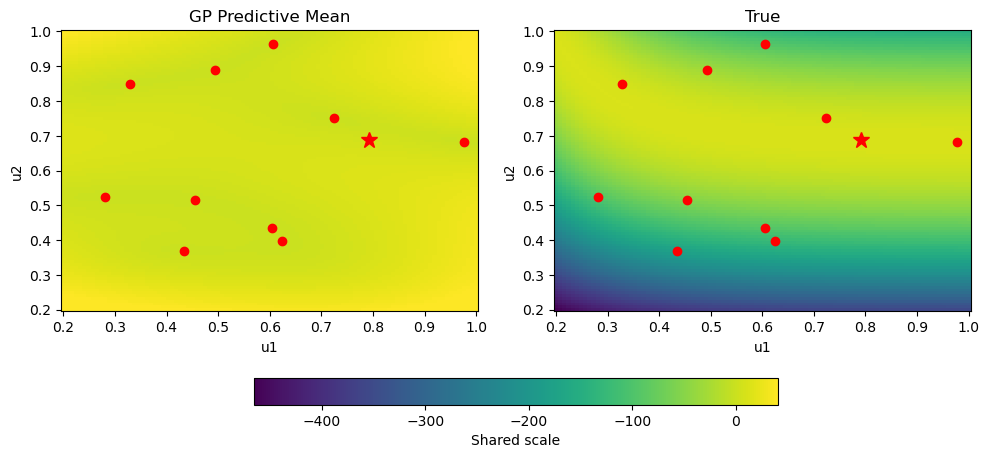

In [ ]:
# Compute shared color limits
vmin = min(np.min(predictive_mean), np.min(log_post_grid))
vmax = max(np.max(predictive_mean), np.max(log_post_grid))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Wider and taller

axs = np.array(axs).reshape(-1)

# Plot 1: GP Predictive Mean
m1 = axs[0].pcolormesh(
    U1_grid,
    U2_grid,
    predictive_std.reshape(U1_grid.shape),
    shading='auto',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
)
axs[0].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[0].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[0].set_title("GP Predictive Mean")
axs[0].set_xlabel("u1")
axs[0].set_ylabel("u2")

# Plot 2: Log Posterior
m2 = axs[1].pcolormesh(
    U1_grid,
    U2_grid,
    log_post_grid,
    shading='auto',
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
)
axs[1].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[1].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[1].set_title("True")
axs[1].set_xlabel("u1")
axs[1].set_ylabel("u2")

fig.tight_layout()

# Give some extra space below for the colorbar
fig.subplots_adjust(bottom=0.18)

# Add horizontal colorbar beneath the plots
cbar = fig.colorbar(
    m1, ax=axs, orientation='horizontal',
    fraction=0.07, pad=0.18
)
cbar.set_label('Shared scale')

fig.show()

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_14336/532488991.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


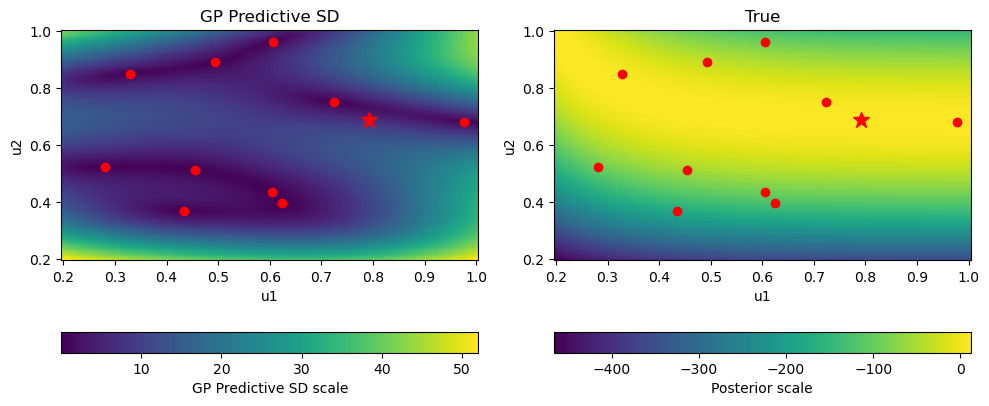

In [17]:
vmin = min(np.min(predictive_std), np.min(log_post_grid))
vmax = max(np.max(predictive_std), np.max(log_post_grid))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs = np.array(axs).reshape(-1)

# --- First plot ---
m1 = axs[0].pcolormesh(
    U1_grid, U2_grid,
    predictive_std.reshape(U1_grid.shape),
    shading='auto', cmap='viridis'
)
axs[0].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[0].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[0].set_title("GP Predictive SD")
axs[0].set_xlabel("u1")
axs[0].set_ylabel("u2")

# --- Second plot ---
m2 = axs[1].pcolormesh(
    U1_grid, U2_grid,
    log_post_grid,
    shading='auto', cmap='viridis'
)
axs[1].plot(*likelihood.par_true, "*", color="red", markersize=12)
axs[1].plot(design.X[:,0], design.X[:,1], "o", color="red")
axs[1].set_title("True")
axs[1].set_xlabel("u1")
axs[1].set_ylabel("u2")

fig.tight_layout()
fig.subplots_adjust(bottom=0.28)  # extra space for both colorbars

# Plot colorbars beneath each plot, horizontally
cbar1 = fig.colorbar(
    m1, ax=axs[0], orientation='horizontal',
    fraction=0.07, pad=0.22
)
cbar1.set_label('GP Predictive SD scale')

cbar2 = fig.colorbar(
    m2, ax=axs[1], orientation='horizontal',
    fraction=0.07, pad=0.22
)
cbar2.set_label('Posterior scale')

fig.show()